# Image Clustering with K-Means

References:
- Tutorial on PCA vs ZCA: http://ufldl.stanford.edu/tutorial/unsupervised/PCAWhitening/
- Functions for image featurization: https://machinelearningmastery.com/image-augmentation-deep-learning-keras/ 
- Kmeans with VCG16 https://towardsdatascience.com/how-to-cluster-images-based-on-visual-similarity-cd6e7209fe34 
- Kmeans with Resnet50 https://towardsdatascience.com/image-clustering-using-transfer-learning-df5862779571
  
Things we want to do in this tutorial:
- K-means clustering on MNIST data (standardization + whitening) -- decent quality
- K-means clustering on MNIST data (standardization + whitening + rotations) -- worse quality
- K-means clustering on MNIST data (standardization + whitening + rotations + transfer learning - VCG16 and Resnet50 with PCA) -- significant improvement in clustering quality

In [1]:
from keras.datasets import mnist
from keras.preprocessing.image import ImageDataGenerator


In [20]:
(x_train, y_train), (_, _) = mnist.load_data()

In [21]:
x_train.shape

(60000, 28, 28)

In [28]:
datagen = ImageDataGenerator(featurewise_center=True,
                             featurewise_std_normalization=True,
                             #zca_whitening=True
                            )

In [29]:
datagen.fit(x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32'))

(10, 28, 28)


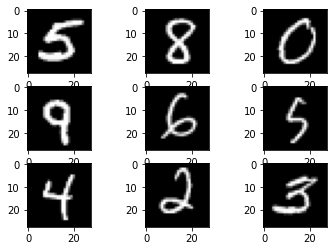

In [31]:
import matplotlib.pyplot as pyplot
for X_batch, y_batch in datagen.flow(x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32'),
                                     y_train,
                                     batch_size=10):
    print(X_batch.reshape(10, 28, 28).shape)
    # create a grid of 3x3 images
    for i in range(0, 9):
        pyplot.subplot(330 + 1 + i)
        pyplot.imshow(X_batch[i].reshape(28, 28), cmap=pyplot.get_cmap('gray'))
    # show the plot
    pyplot.show()
    break

<Figure size 432x288 with 0 Axes>

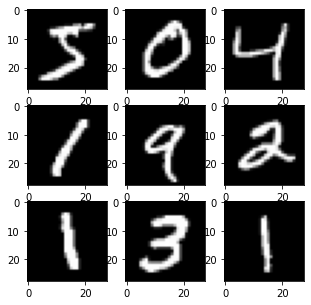

In [11]:
import matplotlib.pyplot as plt
plt.gray();
plt.figure(figsize = (5,5));
for i in range(9):
    plt.subplot(3,3,i+1);
    plt.imshow(x_train[i]);

In [36]:
class MnistDataset:
    
    def __init__(self, zca_whitening=False, rotate=False):
        (self.x_train, self.y_train), (_, _) = mnist.load_data()
        self.width = 28 # image width in pixels
        self.height = 28 # image height in pixels
        self.channels = 1
        if zca_whitening:
            self._zca_whitening()
        if rotate:
            self._random_rotations()
        
    def _process_for_imagedatagenerator(self, image_matrix):
        """Convert image matrix for processing with ImageDataGenerator"""
        reshaped_matrix = image_matrix \
            .reshape((image_matrix.shape[0], self.width, self.height, self.channels))
        return reshaped_matrix.astype('float32')
    
    def _zca_whitening(self):
        """ZCA whitening of dataset images"""
        x_processed = self._process_for_imagedatagenerator(self.x_train)
        datagen = ImageDataGenerator(zca_whitening=True)
        datagen.fit(x_processed)
        for x_batch, y_batch in datagen.flow(x_processed,
                                     self.y_train,
                                     batch_size=x_processed.shape[0]):
            self.x_train = x_batch.reshape(x_processed.shape[0], self.width, self.height)
            break
        
    def _random_rotations(self):
        """Rotate images by 90 degrees"""
        x_processed = self._process_for_imagedatagenerator(self.x_train)
        datagen = ImageDataGenerator(rotation_range=90)
        datagen.fit(x_processed)
        for x_batch, y_batch in datagen.flow(x_processed,
                                     self.y_train,
                                     batch_size=x_processed.shape[0]):
            self.x_train = x_batch.reshape(x_processed.shape[0], self.width, self.height)
            break

In [37]:
baseline_images = MnistDataset()
whitened_images = MnistDataset(zca_whitening=True)
rotated_images = MnistDataset(zca_whitening=True,
                              rotate=True)

/Users/karan/opt/miniconda3/lib/python3.8/site-packages/keras_preprocessing/image/image_data_generator.py:337: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


In [61]:
from sklearn.cluster import MiniBatchKMeans
def get_clustering_labels(image_dataset):
    X = image_dataset.x_train.reshape(len(image_dataset.x_train),-1)
    Y = image_dataset.y_train
    n_digits = 10

    kmeans = MiniBatchKMeans(n_clusters = n_digits)
    kmeans.fit(X)
    return kmeans.labels_


In [62]:
import pandas as pd
import numpy as np
baseline_pred_labels = get_clustering_labels(baseline_images)
data = pd.DataFrame({ 'kmeans_label' : baseline_pred_labels.tolist(),
                      'digit': Y.tolist()})
data.groupby('kmeans_label')['digit'].apply(np.mean).apply(round)

kmeans_label
0    2
1    7
2    6
3    6
4    2
5    4
6    0
7    7
8    2
9    5
Name: digit, dtype: int64

In [63]:
whitened_pred_labels = get_clustering_labels(whitened_images)
data = pd.DataFrame({ 'kmeans_label' : whitened_pred_labels.tolist(),
                      'digit': Y.tolist()})
data.groupby('kmeans_label')['digit'].apply(np.mean).apply(round)

kmeans_label
0    7
1    6
2    6
3    6
4    4
5    4
6    3
7    5
8    3
9    4
Name: digit, dtype: int64

In [64]:
rotated_pred_labels = get_clustering_labels(rotated_images)
data = pd.DataFrame({ 'kmeans_label' : rotated_pred_labels.tolist(),
                      'digit': Y.tolist()})
data.groupby('kmeans_label')['digit'].apply(np.mean).apply(round)

kmeans_label
0    6
1    4
2    4
3    4
4    5
5    4
6    4
7    6
8    3
9    5
Name: digit, dtype: int64